In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datetime import datetime

In [ ]:
# Load the data
from google.colab import files
uploaded = files.upload()


Saving soc-sign-bitcoinotc.csv to soc-sign-bitcoinotc.csv


In [ ]:
import pandas as pd
import io

# Use the filename as the key to access the contents of the file.
filename = next(iter(uploaded.keys()))
df = pd.read_csv(io.BytesIO(uploaded[filename]), header=None, names=['Source', 'Target', 'Rating', 'Time'])
df['Datetime'] = pd.to_datetime(df['Time'], unit='s')


In [ ]:
df.head()

,Source,Target,Rating,Time,Datetime
0,6,2,4,1289241912,2010-11-08 18:45:12
1,6,5,2,1289241942,2010-11-08 18:45:42
2,1,15,1,1289243140,2010-11-08 19:05:40
3,4,3,7,1289245277,2010-11-08 19:41:17
4,13,16,8,1289254254,2010-11-08 22:10:54


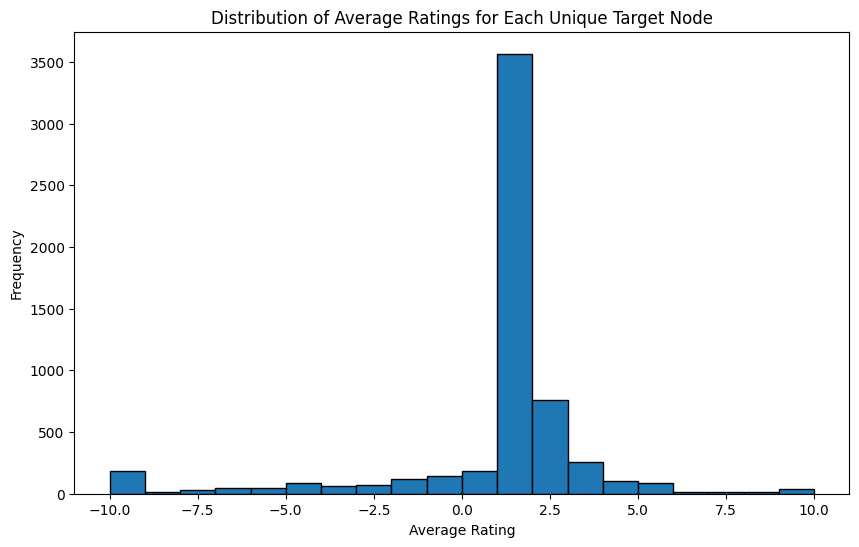

,Target,Avg_Rating,Max_Rating,Min_Rating
0,1,3.544248,10,1
1,2,3.000000,8,-2
2,3,-0.285714,8,-10
3,4,3.111111,10,1
4,5,2.333333,4,1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

# Assuming that the DataFrame `df` is already loaded with the columns 'Source', 'Target', 'Rating', 'Time'

# Calculate average rating for each unique target node
avg_rating_per_target = df.groupby('Target')['Rating'].mean()

# Calculate mode of rating for each target node
#mode_rating_per_target = df.groupby('Target')['Rating'].agg(lambda x: mode(x).mode[0])

# Calculate max rating for each target node
max_rating_per_target = df.groupby('Target')['Rating'].max()

# Calculate min rating for each target node
min_rating_per_target = df.groupby('Target')['Rating'].min()

# Combine all the statistics into one DataFrame
target_rating_stats = pd.DataFrame({
    'Avg_Rating': avg_rating_per_target,
    #'Mode_Rating': mode_rating_per_target,
    'Max_Rating': max_rating_per_target,
    'Min_Rating': min_rating_per_target
}).reset_index()

# Plot the distribution of average ratings
plt.figure(figsize=(10, 6))
avg_rating_per_target.hist(bins=20, edgecolor='black')
plt.title('Distribution of Average Ratings for Each Unique Target Node')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Show the first few rows of the rating statistics for each target node
target_rating_stats.head()


In [ ]:
df.head()

,Source,Target,Rating,Time,Datetime,Year
0,6,2,4,1289241912,2010-11-08 18:45:12,2010
1,6,5,2,1289241942,2010-11-08 18:45:42,2010
2,1,15,1,1289243140,2010-11-08 19:05:40,2010
3,4,3,7,1289245277,2010-11-08 19:41:17,2010
4,13,16,8,1289254254,2010-11-08 22:10:54,2010


In [ ]:
import pandas as pd
import networkx as nx
from community import community_louvain

# Filter DataFrame for the years 2011 to 2015
df['Year'] = pd.to_datetime(df['datetime'], unit='s').dt.year
filtered_df = df[df['Year'].between(2011, 2015)]

# Create yearly graphs and detect communities
yearly_communities = {}
for year in range(2011, 2016):
    yearly_df = filtered_df[filtered_df['Year'] == year]
    G_year = nx.from_pandas_edgelist(yearly_df, 'source', 'target', edge_attr=True, create_using=nx.Graph())
    partition = community_louvain.best_partition(G_year)
    # Store communities identified in each year
    yearly_communities[year] = partition

# Find the "scarce" community for 2013 by the fewest nodes
communities_2013 = yearly_communities[2013]
community_sizes_2013 = pd.Series(communities_2013).value_counts()
scarce_community_id = community_sizes_2013.idxmin()

# Identify nodes in the most scarce community of 2013
scarce_community_nodes = [node for node, community_id in communities_2013.items() if community_id == scarce_community_id]

print(f"Most scarce community in 2013 has {len(scarce_community_nodes)} nodes.")

# Track the trend of this community from 2011 to 2015
community_trends = {}
for year in range(2011, 2016):
    # Count how many nodes from the scarce community of 2013 are present in each year's communities
    community_membership = pd.Series(yearly_communities[year])
    community_trends[year] = sum(community_membership.isin(scarce_community_nodes))

# Display the trend of the community from 2011 to 2015
for year, size in community_trends.items():
    print(f"Year {year}: {size} nodes from the 2013 scarce community")


Most scarce community in 2013 has 2 nodes.
Year 2011: 0 nodes from the 2013 scarce community
Year 2012: 0 nodes from the 2013 scarce community
Year 2013: 0 nodes from the 2013 scarce community
Year 2014: 0 nodes from the 2013 scarce community
Year 2015: 0 nodes from the 2013 scarce community


In [ ]:
import pandas as pd
import networkx as nx
from community import community_louvain

# Assuming df is your DataFrame with columns 'Source', 'Target', 'Time', and it's already filtered for 2011-2015.

# Convert 'Time' to datetime and extract year
df['Year'] = pd.to_datetime(df['datetime'], unit='s').dt.year

# Create a graph for each year and detect communities
yearly_graphs = {}
yearly_partitions = {}
for year in range(2011, 2016):
    yearly_df = df[df['Year'] == year]
    G_year = nx.from_pandas_edgelist(yearly_df, 'source', 'target', edge_attr=True, create_using=nx.Graph())
    partition = community_louvain.best_partition(G_year)
    yearly_graphs[year] = G_year
    yearly_partitions[year] = partition

# Identify the community in 2013 with the fewest nodes
partition_2013 = yearly_partitions[2013]
community_ids_2013 = set(partition_2013.values())
community_sizes_2013 = {community_id: list(partition_2013.values()).count(community_id) for community_id in community_ids_2013}
scarce_community_id_2013 = min(community_sizes_2013, key=community_sizes_2013.get)
scarce_community_nodes_2013 = [node for node, community_id in partition_2013.items() if community_id == scarce_community_id_2013]

# Track the nodes of the 2013 scarce community across other years
community_presence = {year: [] for year in range(2011, 2016)}
for year, partition in yearly_partitions.items():
    for node in scarce_community_nodes_2013:
        if node in partition:
            community_presence[year].append((node, partition[node]))

# Summarize community presence over the years
for year in range(2011, 2016):
    nodes_present = [node for node, _ in community_presence[year]]
    community_ids = set([community_id for _, community_id in community_presence[year]])
    print(f"Year {year}: {len(nodes_present)} nodes from the 2013 scarce community were present in communities {community_ids}")


Year 2011: 0 nodes from the 2013 scarce community were present in communities set()
Year 2012: 0 nodes from the 2013 scarce community were present in communities set()
Year 2013: 2 nodes from the 2013 scarce community were present in communities {0}
Year 2014: 0 nodes from the 2013 scarce community were present in communities set()
Year 2015: 0 nodes from the 2013 scarce community were present in communities set()


In [ ]:
df.head()

,source,target,rating,time,datetime,Year
0,6,2,4,1289241912,2010-11-08 18:45:12,2010
1,6,5,2,1289241942,2010-11-08 18:45:42,2010
2,1,15,1,1289243140,2010-11-08 19:05:40,2010
3,4,3,7,1289245277,2010-11-08 19:41:17,2010
4,13,16,8,1289254254,2010-11-08 22:10:54,2010


Number of nodes: 2
Number of edges: 1
Density: 1.0000

Top 3 nodes by Degree Centrality: [(3762, 1.0), (3763, 1.0)]
Top 3 nodes by Betweenness Centrality: [(3762, 0.0), (3763, 0.0)]
Top 3 nodes by Closeness Centrality: [(3762, 1.0), (3763, 1.0)]
Top 3 nodes by Eigenvector Centrality: [(3762, 0.7071067811865476), (3763, 0.7071067811865476)]


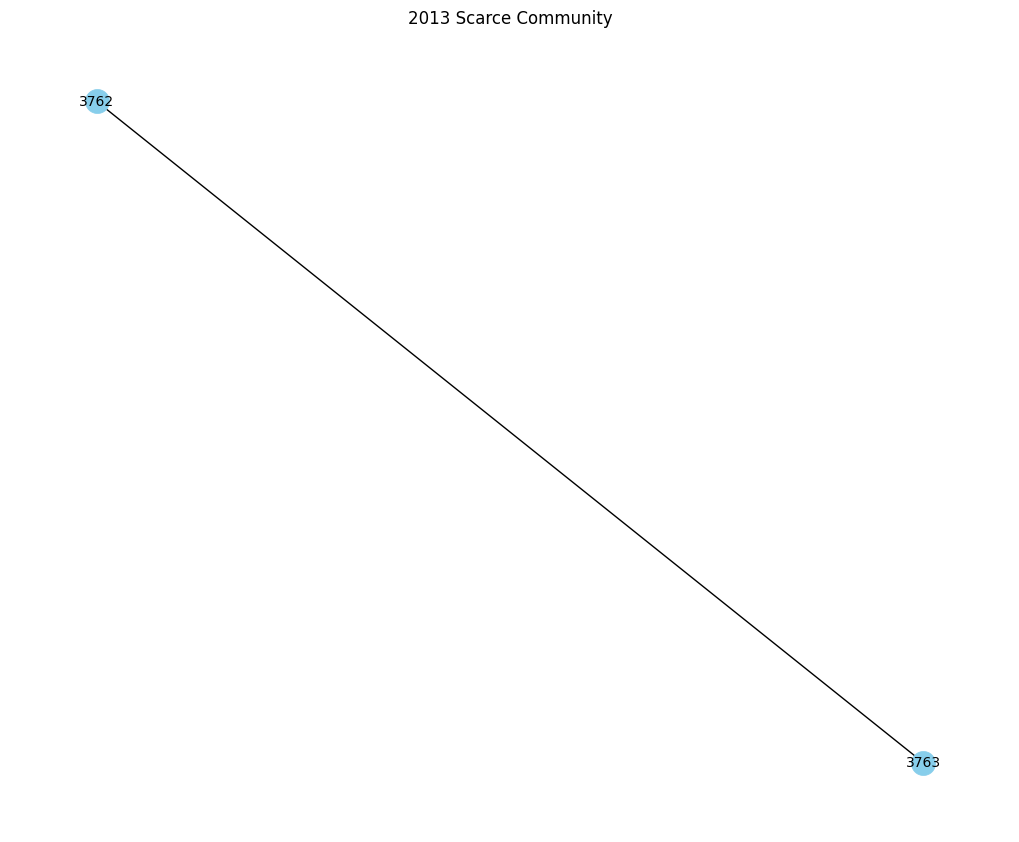

In [ ]:
# Extract the graph for 2013
G_2013 = yearly_graphs[2013]

# Create a subgraph for the scarce community identified in 2013
scarce_community_subgraph = G_2013.subgraph(scarce_community_nodes_2013)

# Analyze the community structure
print(f"Number of nodes: {scarce_community_subgraph.number_of_nodes()}")
print(f"Number of edges: {scarce_community_subgraph.number_of_edges()}")
density = nx.density(scarce_community_subgraph)
print(f"Density: {density:.4f}")

# Calculate node-level metrics for nodes within the scarce community
degree_centrality = nx.degree_centrality(scarce_community_subgraph)
betweenness_centrality = nx.betweenness_centrality(scarce_community_subgraph)
closeness_centrality = nx.closeness_centrality(scarce_community_subgraph)
eigenvector_centrality = nx.eigenvector_centrality(scarce_community_subgraph, max_iter=1000)

# Identify top nodes based on centrality measures
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:3]

print("\nTop 3 nodes by Degree Centrality:", top_degree)
print("Top 3 nodes by Betweenness Centrality:", top_betweenness)
print("Top 3 nodes by Closeness Centrality:", top_closeness)
print("Top 3 nodes by Eigenvector Centrality:", top_eigenvector)

# Visualization of the scarce community
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(scarce_community_subgraph)
nx.draw(scarce_community_subgraph, pos, with_labels=True, node_color='skyblue', edge_color='k', linewidths=0.5, font_size=10)
plt.title("2013 Scarce Community")
plt.show()


High Density: The density of 1.0000 shows that the community is fully connected, which is expected given there are only two nodes and one edge. In larger communities, a high density might indicate a closely knit group with frequent interactions.

Centrality Measures: All centrality measures are equal for both nodes, indicating their equal importance within this small community. The eigenvector centrality values suggest that these nodes are equally central in terms of their connections within the community.

No Betweenness Centrality: A betweenness centrality of 0.0 for both nodes indicates that neither node acts as a 'bridge' within the community. This is consistent with the community's size, as there are no alternative paths through the community other than the direct connection.

In [ ]:
# Assuming 'rating' is an edge attribute in your graph
edge_ratings = [(u, v, d['rating']) for u, v, d in scarce_community_subgraph.edges(data=True)]
average_rating = np.mean([rating for _, _, rating in edge_ratings])
print(f"Average interaction rating in the scarce community: {average_rating:.2f}")


Average interaction rating in the scarce community: 1.00


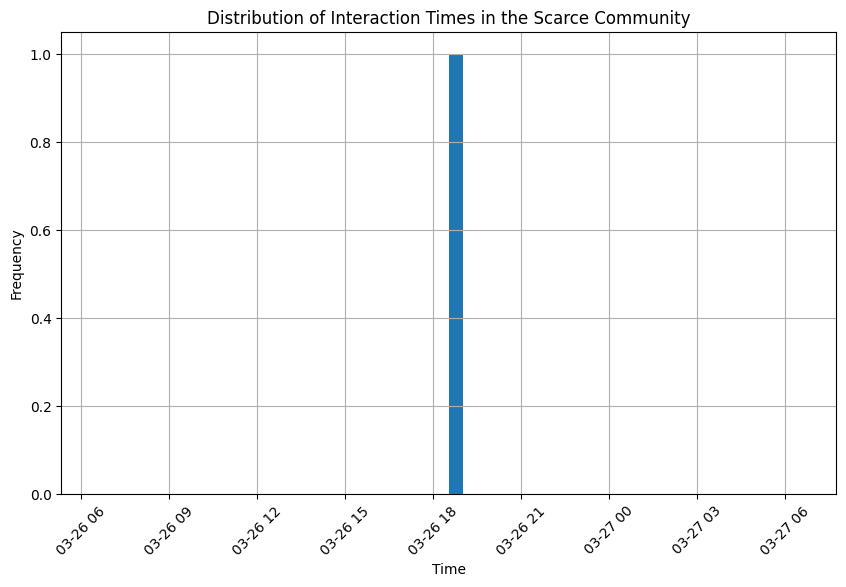

In [ ]:
# Extract timestamps for interactions within the scarce community
interaction_times = [d['time'] for u, v, d in scarce_community_subgraph.edges(data=True)]
interaction_dates = pd.to_datetime(interaction_times, unit='s')
interaction_dates_series = pd.Series(interaction_dates)

plt.figure(figsize=(10, 6))
interaction_dates_series.hist(bins=50)  # Adjust the number of bins as needed
plt.title("Distribution of Interaction Times in the Scarce Community")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.show()


In [ ]:
# Regenerate the edge boundary generator if needed
boundary_edges = nx.edge_boundary(G_2013, scarce_community_nodes_2013)

# Identify unique nodes outside the scarce community connected by boundary edges
external_nodes = set([v for _, v in boundary_edges if v not in scarce_community_nodes_2013])
print(f"Number of unique external nodes connected: {len(external_nodes)}")


Number of unique external nodes connected: 0


In [ ]:
# Assuming 'rating' can be an indicator of positive/negative interactions
positive_interactions = sum(1 for _, _, rating in edge_ratings if rating > 0)
negative_interactions = sum(1 for _, _, rating in edge_ratings if rating < 0)

print(f"Positive interactions: {positive_interactions}")
print(f"Negative interactions: {negative_interactions}")


Positive interactions: 1
Negative interactions: 0


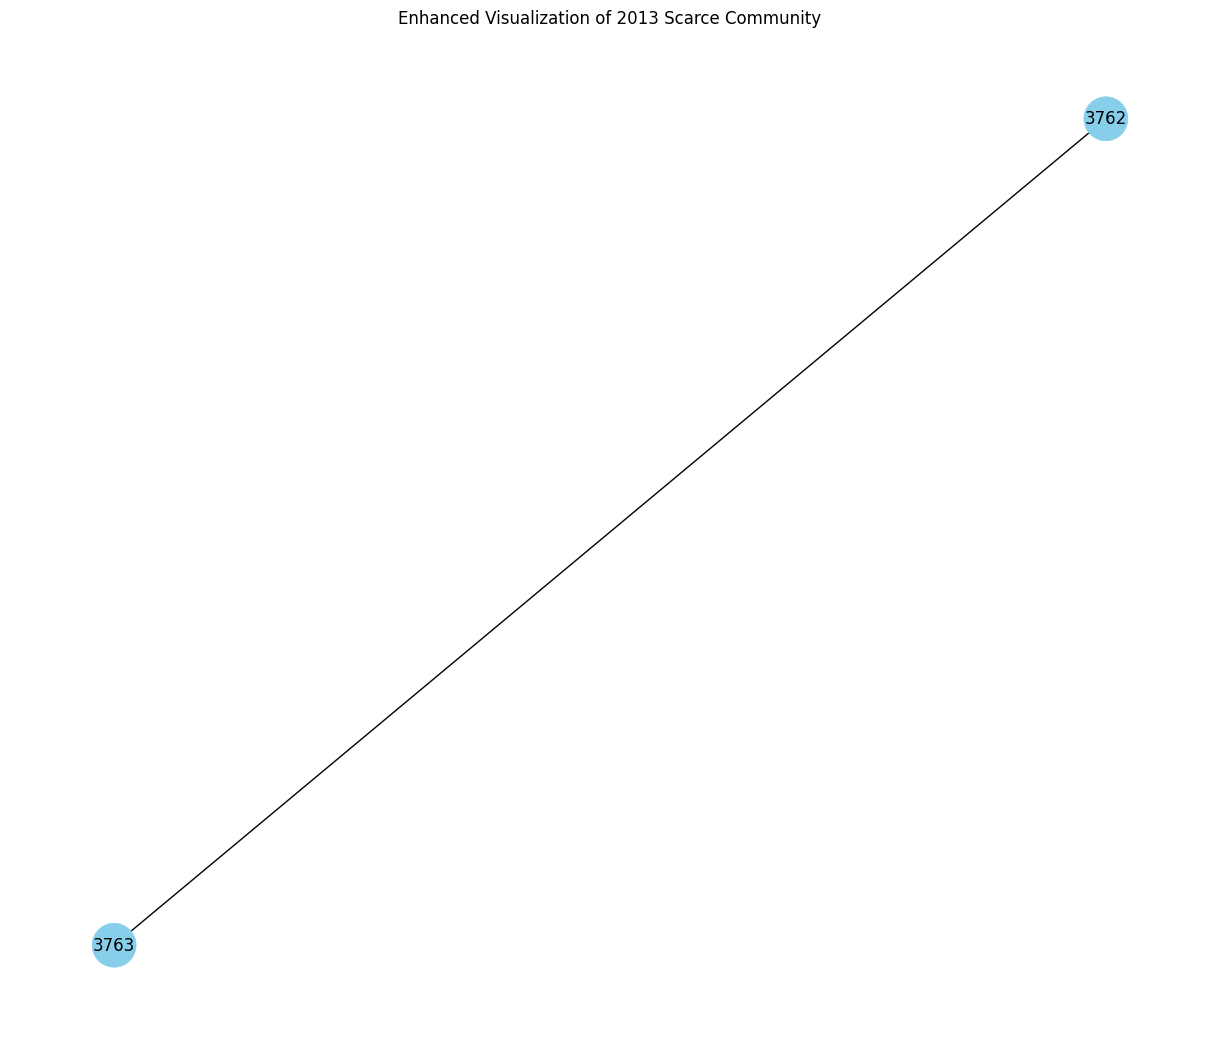

In [ ]:
# Node size by degree centrality
node_sizes = [v * 1000 for v in degree_centrality.values()]

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(scarce_community_subgraph)
nx.draw(scarce_community_subgraph, pos, with_labels=True, node_size=node_sizes, node_color='skyblue', edge_color='k', linewidths=0.5, font_size=12)
plt.title("Enhanced Visualization of 2013 Scarce Community")
plt.show()


In [ ]:
# Create a directed weighted graph
G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight', 'datetime'], create_using=nx.DiGraph())

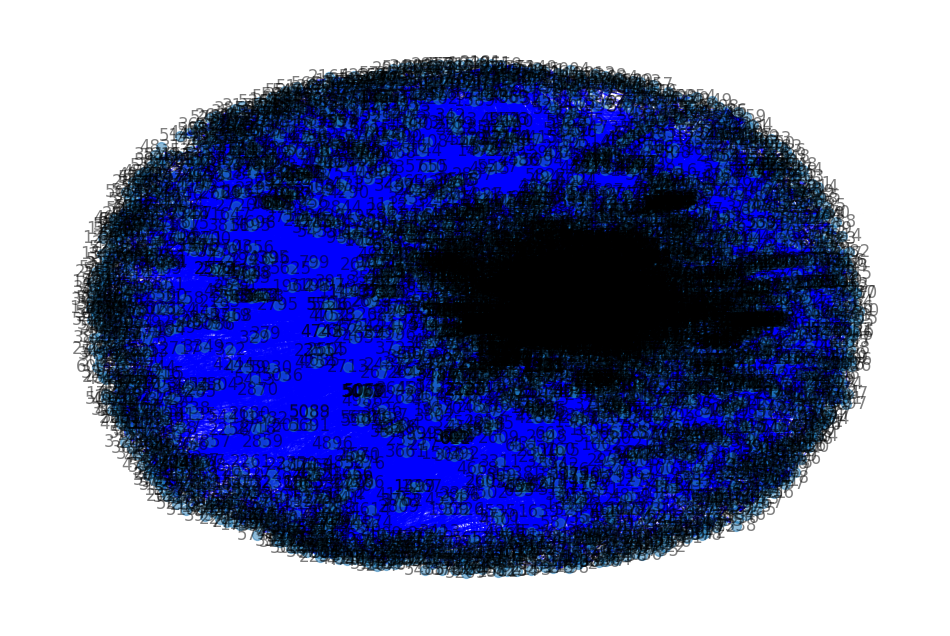

In [ ]:
# Set up the plot size
plt.figure(figsize=(12, 8))

# Draw the network
nx.draw_networkx(G, with_labels=True, node_size=50, edge_color='blue', alpha=0.5)

# Display the plot
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot in the output cell

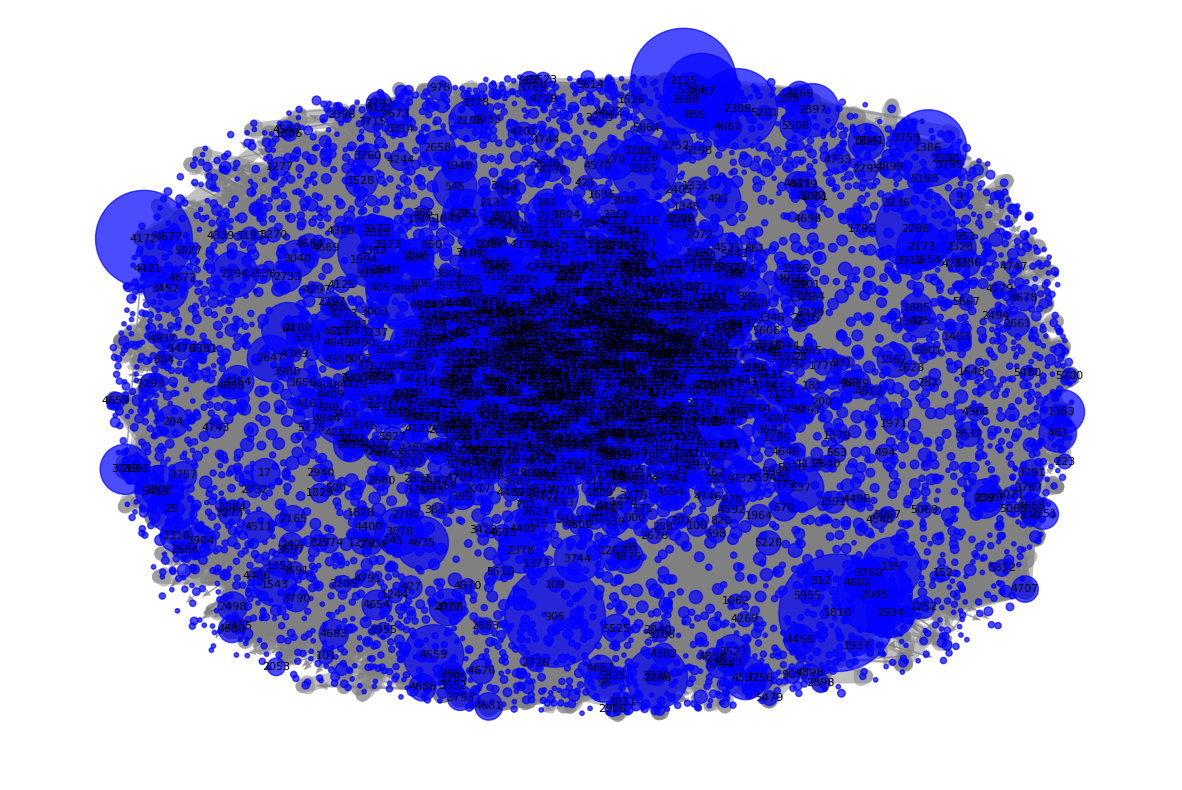

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Set up the plot size
plt.figure(figsize=(15, 10))

# Use a layout that spreads nodes using the Fruchterman-Reingold algorithm
pos = nx.spring_layout(G, k=0.1, iterations=20)

# Draw the network with varying node size and edge width
node_degree = nx.degree(G)
node_size = [v * 10 for k, v in dict(node_degree).items()]
edge_width = [d['weight'] for (u, v, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='grey', alpha=0.5)

# If you want to label only the most significant nodes
important_nodes = [node for node, degree in dict(G.degree()).items() if degree > 10] # adjust threshold as needed
nx.draw_networkx_labels(G, pos, labels={n: n for n in important_nodes}, font_size=8, font_color='black')

# Turn off the axis
plt.axis('off')

# Show the plot
plt.show()


In [ ]:
# Degree Centrality: Importance based on the number of links held by nodes
degree_centrality = nx.degree_centrality(G)

# Betweenness Centrality: Importance based on the number of shortest paths that pass through the node
betweenness_centrality = nx.betweenness_centrality(G)

# Closeness Centrality: Importance based on how close a node is to all other nodes in the network
closeness_centrality = nx.closeness_centrality(G)

# Eigenvector Centrality: Importance based on how well a node is connected to other highly connected nodes
eigenvector_centrality = nx.eigenvector_centrality(G)


In [ ]:
# Find the top N nodes by degree centrality
top_n = 10  # Set the number of top nodes you want
top_degree_centrality_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]

# Print the top nodes with their degree centrality
for node, centrality_value in top_degree_centrality_nodes:
    print(f'Node {node} has a degree centrality of {centrality_value}')


Node 35 has a degree centrality of 0.22074829931972786
Node 2642 has a degree centrality of 0.1391156462585034
Node 1810 has a degree centrality of 0.12159863945578231
Node 2125 has a degree centrality of 0.09812925170068026
Node 2028 has a degree centrality of 0.09727891156462584
Node 905 has a degree centrality of 0.08979591836734693
Node 4172 has a degree centrality of 0.08265306122448979
Node 7 has a degree centrality of 0.07619047619047618
Node 1 has a degree centrality of 0.075
Node 4197 has a degree centrality of 0.06887755102040816


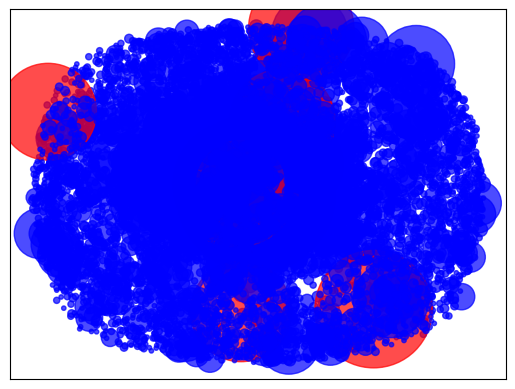

In [ ]:
# Visualize the top centrality nodes with a different color or size
top_nodes = [node for node, centrality_value in top_degree_centrality_nodes]
node_color = ['red' if node in top_nodes else 'blue' for node in G]

# Use the node color in the visualization
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.7)


# **Community**

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


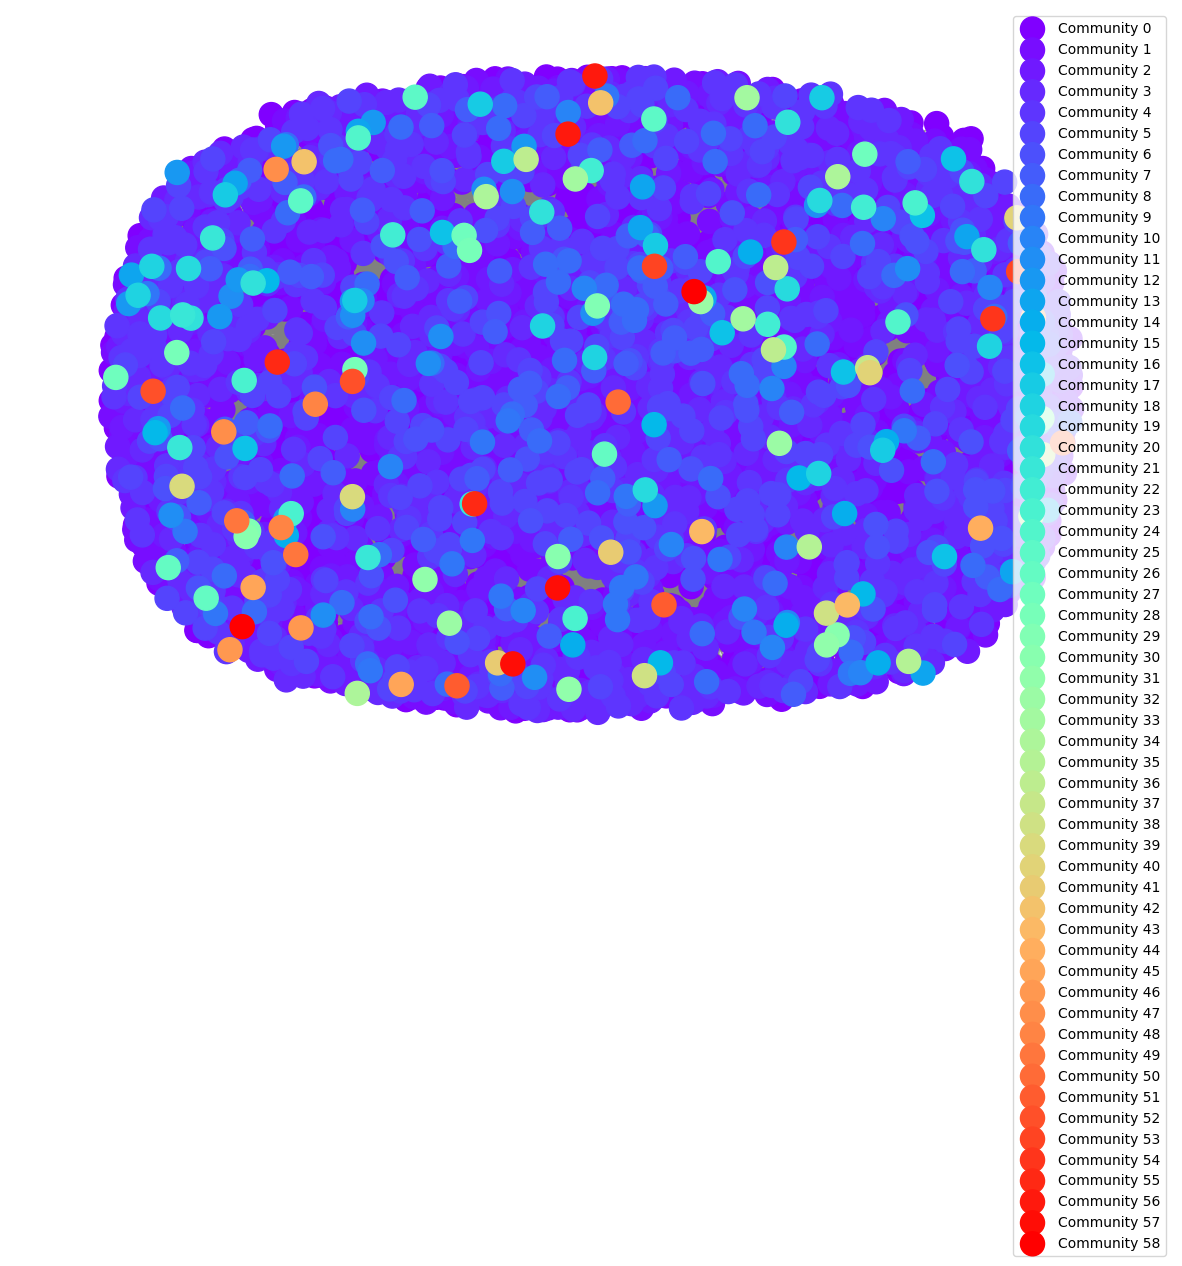

In [ ]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community

# Detect communities using modularity-based algorithms
communities = community.greedy_modularity_communities(G)

# Create a mapping from node label to community index
community_index = {node: i for i, com in enumerate(communities) for node in com}

# Map community index to a color
colors = cm.rainbow(np.linspace(0, 1, len(communities)))
community_color = {node: colors[i] for node, i in community_index.items()}

# Set up the plot size
plt.figure(figsize=(15, 10))

# Choose a layout for our nodes
pos = nx.spring_layout(G, k=0.1, iterations=20)

# Draw the network
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="gray")

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[colors[i]] * len(community), label=f"Community {i}")

# If you want to label nodes (optional, may make the plot cluttered)
# nx.draw_networkx_labels(G, pos)

# Turn off the axis
plt.axis('off')

# Show the legend
plt.legend(scatterpoints=1)

# Show the plot
plt.show()

# **Bipartite**

The graph is bipartite: True


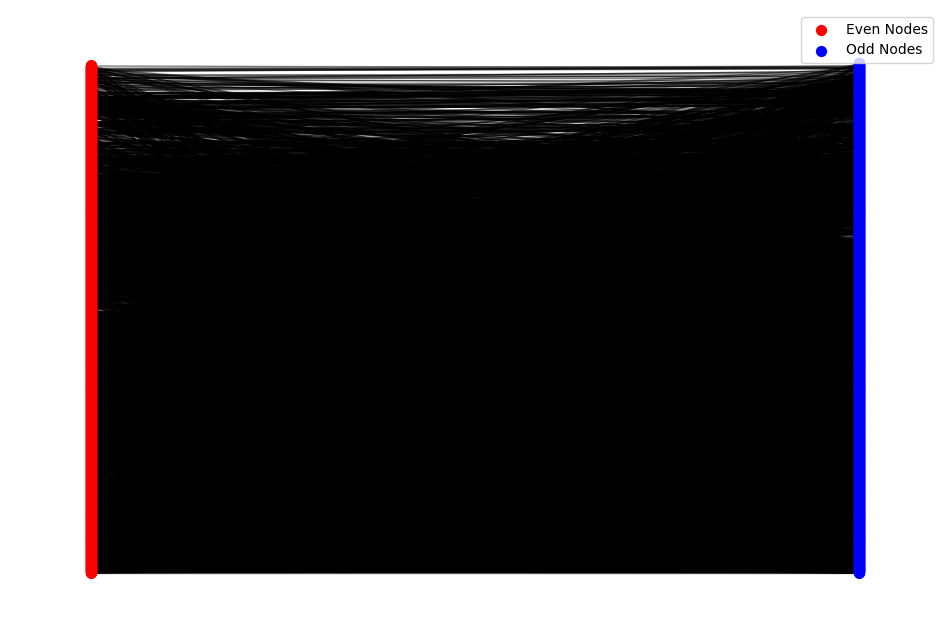

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite

# Define nodes with even and odd IDs
nodes_even = {n for n in G if n % 2 == 0}
nodes_odd = set(G) - nodes_even

# Create the bipartite graph B
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes_even, bipartite=0)
B.add_nodes_from(nodes_odd, bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from((n, m) for n, m in G.edges() if n in nodes_even and m in nodes_odd)

# Check if the graph B is bipartite
is_bipartite = bipartite.is_bipartite(B)
print(f"The graph is bipartite: {is_bipartite}")

# Use a bipartite layout if the graph is bipartite
if is_bipartite:
    # Position the nodes in two distinct columns
    pos = {node: (0, index) for index, node in enumerate(nodes_even)}
    pos.update({node: (1, index) for index, node in enumerate(nodes_odd)})

    # Set up the plot size
    plt.figure(figsize=(12, 8))

    # Draw the network
    nx.draw_networkx_nodes(B, pos, nodelist=nodes_even, node_color='red', label='Even Nodes', node_size=50)
    nx.draw_networkx_nodes(B, pos, nodelist=nodes_odd, node_color='blue', label='Odd Nodes', node_size=50)
    nx.draw_networkx_edges(B, pos, width=1.0, alpha=0.5)

    # Labels (optional)
    # nx.draw_networkx_labels(B, pos)

    # Turn off the axis
    plt.axis('off')

    # Show the plot with a legend
    plt.legend()
    plt.show()
else:
    print("The given graph cannot be structured as a bipartite graph based on even and odd nodes.")


# **Link prediction using common neighbors**

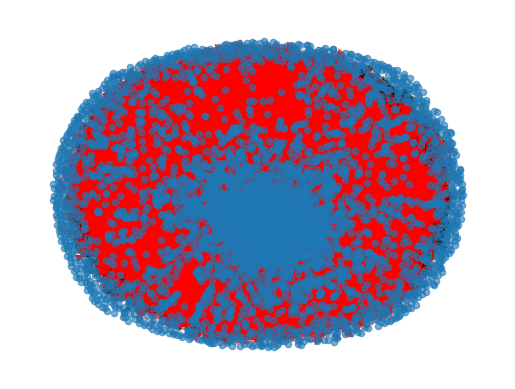

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Get all possible non-edges (pairs of nodes that don't have an edge)
all_nodes = set(G.nodes())
non_edges = [(u, v) for u, v in combinations(all_nodes, 2) if not G.has_edge(u, v) and not G.has_edge(v, u)]

# Predict links using a directed version of common neighbors
# Here we look for nodes that have common successors
predicted_links = []
for u, v in non_edges:
    common_successors = set(G.successors(u)).intersection(set(G.successors(v)))
    if len(common_successors) > 2:
        predicted_links.append((u, v))

# Now we visualize the original graph with the predicted links highlighted
pos = nx.spring_layout(G)  # Use spring layout for the positions of nodes

# Draw the existing nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20, alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Draw the predicted edges in red
nx.draw_networkx_edges(G, pos, edgelist=predicted_links, edge_color='r', alpha=0.6, style='dashed')

# Turn off the axis
plt.axis('off')

# Show the plot
plt.show()
